<a href="https://colab.research.google.com/github/deguc/datascience/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

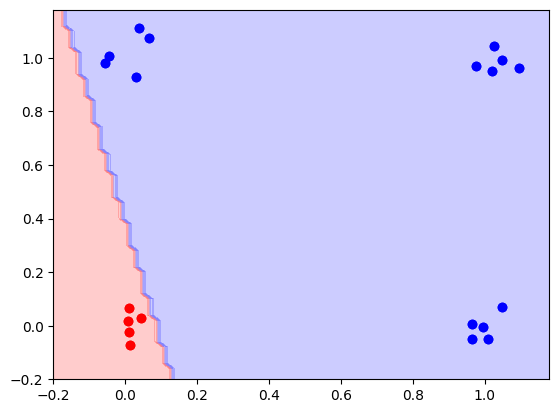

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


#マルチレイヤーネットワーク

def DateSets(y=[0,1,1,1],N=50,loc=0,scale=0.05):

  #N=10         データのサイズ
  #loc          平均
  #scale=0.05   標準偏差

  X_=np.array([[0,0],[0,1],[1,0],[1,1]])#学習用データ

  #元のデータにノイズを足す。
  X0=X_[0]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X1=X_[1]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X2=X_[2]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X3=X_[3]+np.random.normal(size=(N,2),loc=loc,scale=scale)
  X=np.concatenate((X0,X1,X2,X3))   #データを結合する。

  #正解ラベル
  y0=np.full(N,y[0])
  y1=np.full(N,y[1])
  y2=np.full(N,y[2])
  y3=np.full(N,y[3])
  y=np.concatenate((y0,y1,y2,y3))   #データを結合する

  return X,y

def Plot(X,y,c=['red','blue','green','orange']):
  #データをプロットする。
  n=y.max()
  for k in range(n+1):
    plt.scatter(X[y==k,0],X[y==k,1],c=c[k]);

def decision_regions(x,y,model):

  #平面を分割する。

  #カラーマップの準備
  colors=['red','blue','green','orange']
  cmap=ListedColormap(colors[:len(np.unique(y))])

  #グリッドの作成
  x1=np.arange(-0.2,1.2,0.02)   #横軸
  x2=np.arange(-0.2,1.2,0.02)   #縦軸
  xx1,xx2=np.meshgrid(x1,x2)    #メッシュ
  z=np.array([xx1.ravel(),xx2.ravel()]).T   #座標点の作成

  Z=model(z).reshape(xx1.shape)   #各座標点を分類する

  Plot(x,y,c=colors) #データをプロットする。

  plt.contourf(xx1,xx2,Z,alpha=0.2,cmap=cmap) #平面の分割
  plt.show()




class Perceptron:

  def __init__(self):

    #コンストラクタ

    self.W=np.random.randn(2,)   #重みの初期化
    self.b=0      #バイアスの初期化

    self.x=None   #入力データの保存

  def forward(self,x):

    #順伝播

    a=np.matmul(x,self.W)+self.b  #アフィン変換

    self.x=x  #入力データを保存

    y=(a>0)*1 #ステップ関数

    return y

  def backward(self,delta):

    #逆伝播

    #勾配を計算
    dW=np.matmul(self.x.T,delta)
    db=np.sum(delta,axis=0)

    #重みとバイアスの更新
    self.W-=0.1*dW
    self.b-=0.1*db
    return None

  def fit(self,x,t,epochs=100):

    #学習

    for __ in range(epochs):
      y=self.forward(x)   #予測
      delta=y-t           #誤差
      self.backward(delta)  #重みとバイアスを更新

    return None

  def predict(self,x):
    #予測
    return self.forward(x)

  def __call__(self,x):
    return self.predict(x)


X,y=DateSets(y=[0,1,1,1],N=5)


model=Perceptron()    #インスタンス化

model.fit(X,y)    #学習

pred=model(X)   #学習結果の確認


Plot(X,y)
decision_regions(X,y,model)


